# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
import os
import math
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report

# openCV for image processing
import cv2

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Initialization

In [2]:
rn = 42
epochs = 50
batch_size = 64

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

np.random.seed(rn)
random.seed(rn)
tf.random.set_seed(rn)
tf.get_logger().setLevel('ERROR')


early_stopping = EarlyStopping(
    monitor='recall',
    mode = 'max',
    patience=10,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='recall',
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-6
)

## Loading the dataset

In [3]:
images = np.load('../data/cnn/images.npy')
labels = pd.read_csv('../data/cnn/labels.csv')

## Data Overview

### Understand the shape of the dataset

In [4]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB images, each with a shape of 128 x 128 and 3 color channels.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [5]:
def plot_images(images,labels):
    unique_categories = np.unique(labels)
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    axes = axes.ravel()

    for idx, category in enumerate(unique_categories):
        category_index = np.where(labels == category)[0][0]
        image = images[category_index]

        # Plot the image
        axes[idx].imshow(image, cmap='gray' if image.ndim == 2 else None)
        axes[idx].set_title(category)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

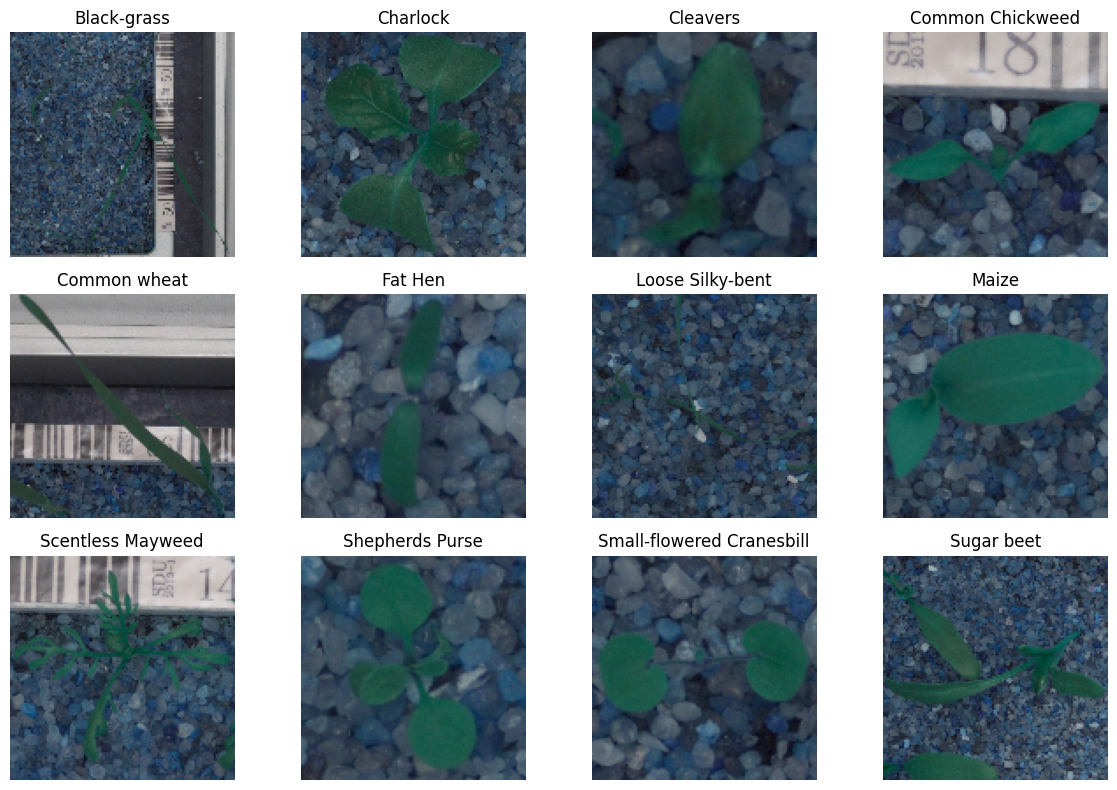

In [6]:
plot_images(images,labels)

**Observation:**
- The colors in the image appear incorrect, with a noticeable blue tint. To address this, we will convert the image from BGR to RGB, as libraries like Matplotlib require images in RGB format. Before proceeding, let’s check for data imbalance in the dataset.

<b> Checking for data imbalance

In [7]:
labels['Label'].value_counts()

Label
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: count, dtype: int64

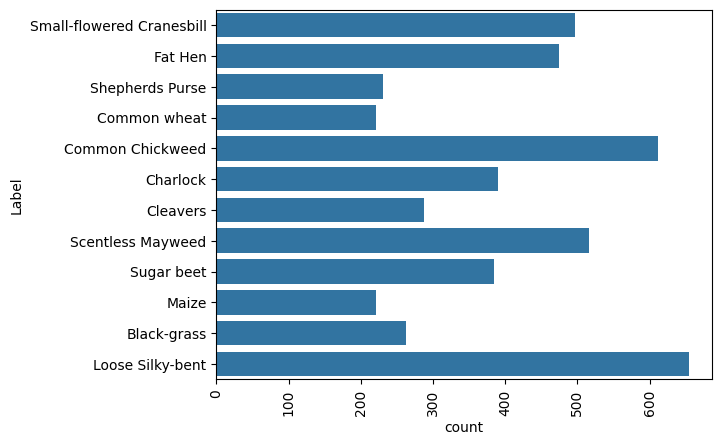

In [8]:
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')
plt.show()

**Observation:**
- As seen in the above plot, the dataset is highly imbalanced.
- Some categories, such as Maize and Common Wheat, have fewer than 300 images, while others, like Loose Silky-bent and Common Chickweed, have more than 600 images.

## Data Pre-Processing

### Convert the BGR images to RGB images.

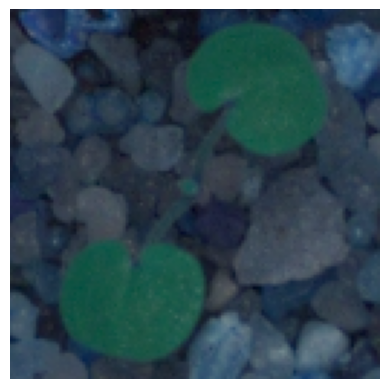

In [9]:
# image before conversion
plt.imshow(images[5])
plt.axis('off')
plt.show()

In [10]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

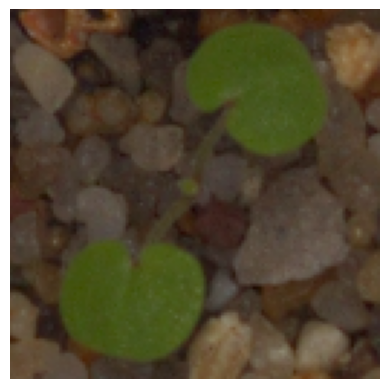

In [11]:
# same image after conversion
plt.imshow(images[5])
plt.axis('off')
plt.show()

### Resize the images

As the original image size is quite large, training on them could be computationally expensive. Therefore, it is better to reduce the image size from 128x128 to 64x64 to make the training process more efficient.

In [12]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_AREA))

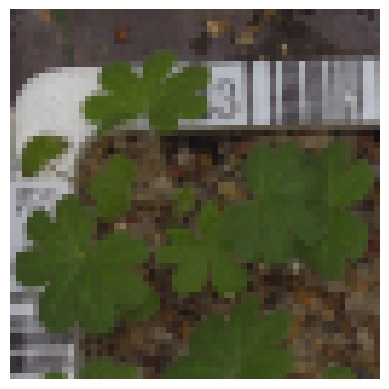

In [13]:
plt.imshow(images_decreased[3])
plt.axis('off')
plt.show()

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data.
- We'll have to encode categorical features and scale the pixel values.
- We will build a model using the train data and then check its performance.

**Split the dataset**

In [14]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=rn, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.2, random_state=rn, stratify=y_temp)

In [15]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3420, 64, 64, 3) (3420, 1)
(855, 64, 64, 3) (855, 1)
(475, 64, 64, 3) (475, 1)


In [16]:
print(f"After splitting training data has {y_train['Label'].nunique()} unique classes.")
print(f"After splitting validation data has {y_val['Label'].nunique()} unique classes.")
print(f"After splitting test data has {y_test['Label'].nunique()} unique classes.")

After splitting training data has 12 unique classes.
After splitting validation data has 12 unique classes.
After splitting test data has 12 unique classes.


All three splits—train, validation, and test—contain all the classes, which ensures that we can accurately measure the performance of our model.

### Encode the target labels

In [17]:
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

class_mapping = dict(enumerate(enc.classes_))
print("Mapping of integers to classes:", class_mapping)

Mapping of integers to classes: {0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}


### Claculate Class Weights

Earlier, we identified that our dataset is imbalanced. To address this, we’ve ensured that all datasets (training, testing, and validation) have the same class distribution. Now, we will calculate the class ratios to adjust for class imbalance during model building, ensuring no class gets undue importance and that we achieve better generalization.

In [18]:
y_train_int = np.argmax(y_train_encoded, axis=1)
print("Integer labels:\n", np.unique(y_train_int))

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int), y=y_train_int)
cw_dict = dict(enumerate(class_weights))

print("Class Weights (Integer):", cw_dict)

Integer labels:
 [ 0  1  2  3  4  5  6  7  8  9 10 11]
Class Weights (Integer): {0: 1.5, 1: 1.0142348754448398, 2: 1.383495145631068, 3: 0.6477272727272727, 4: 1.7924528301886793, 5: 0.8333333333333334, 6: 0.6050955414012739, 7: 1.7924528301886793, 8: 0.7681940700808625, 9: 1.716867469879518, 10: 0.7983193277310925, 11: 1.025179856115108}


### Data Normalization

In [19]:
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

Let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>


The following functions will assist in building the model and evaluating its performance. Instead of repeatedly writing the same commands, we will use these five functions to streamline the process.

In [20]:
def build_base_model(name=None):
    
    backend.clear_session()
    model = Sequential(name=name)     # Intializing a sequential model
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding = 'same'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D((2, 2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D((2, 2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D((2, 2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    if name == 'CNN-Baseline':
        model.add(Flatten())
    else:
        model.add(GlobalAveragePooling2D()) # to mitigate overfitting for complex models
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(12, activation='softmax'))
    
    opt=Adam()
    #opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(), 'accuracy'])
    model.summary()
    return model

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





In [21]:
def plot_confusion_matrix(y_pred,y_test_encoded,title=None):
    y_pred_arg=np.argmax(y_pred,axis=1)
    y_test_arg=np.argmax(y_test_encoded,axis=1)
    
    confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)  
    plt.show()

In [22]:
def plot_train_vs_val_recall(history_name):
    plt.plot(history_name.history['recall'])
    plt.plot(history_name.history['val_recall'])
    plt.title('Model Recall Performance')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [23]:
def plot_loss(history, name):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots()
    ax.plot(history.history[name], label='Train')
    ax.plot(history.history['val_' + name], label='Validation')
    ax.set_title('Model ' + name.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name.capitalize())
    ax.legend(bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [24]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    pred = np.argmax(model.predict(predictors), axis=1)
    true_val = np.argmax(target, axis=1)
    
    acc = accuracy_score(true_val, pred)
    recall = recall_score(true_val, pred, average='macro')  
    precision = precision_score(true_val, pred, average='macro')
    f1 = f1_score(true_val, pred, average='macro')

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},
        index=[0],
    )

    return df_perf

### <b> First model: CNN Baseline

In [25]:
base_cnn_model = build_base_model(name="CNN-Baseline")

Model: "CNN-Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)       

### <b> Fitting the model on the train data

In [26]:
start = time.time()
base_cnn_history = base_cnn_model.fit(
            X_train_normalized, y_train_encoded,
            epochs = epochs,
            validation_data = (X_val_normalized,y_val_encoded),
            batch_size = batch_size,
            callbacks = [early_stopping],
            class_weight = cw_dict,
            verbose = 2
)
end=time.time()

Epoch 1/50
54/54 - 3s - loss: 4.3003 - recall: 0.2424 - accuracy: 0.2678 - val_loss: 5.3943 - val_recall: 0.0468 - val_accuracy: 0.0468 - 3s/epoch - 63ms/step
Epoch 2/50
54/54 - 2s - loss: 3.1931 - recall: 0.4175 - accuracy: 0.4354 - val_loss: 11.8213 - val_recall: 0.0468 - val_accuracy: 0.0468 - 2s/epoch - 42ms/step
Epoch 3/50
54/54 - 2s - loss: 2.6957 - recall: 0.5015 - accuracy: 0.5152 - val_loss: 21.1031 - val_recall: 0.0468 - val_accuracy: 0.0468 - 2s/epoch - 43ms/step
Epoch 4/50
54/54 - 2s - loss: 2.5167 - recall: 0.5488 - accuracy: 0.5620 - val_loss: 20.0713 - val_recall: 0.0468 - val_accuracy: 0.0468 - 2s/epoch - 43ms/step
Epoch 5/50
54/54 - 2s - loss: 2.7178 - recall: 0.5716 - accuracy: 0.5816 - val_loss: 21.3274 - val_recall: 0.0386 - val_accuracy: 0.0596 - 2s/epoch - 43ms/step
Epoch 6/50
54/54 - 2s - loss: 2.8432 - recall: 0.5845 - accuracy: 0.5912 - val_loss: 24.5909 - val_recall: 0.1380 - val_accuracy: 0.1380 - 2s/epoch - 41ms/step
Epoch 7/50
54/54 - 2s - loss: 2.8718 - re

In [27]:
print("Time taken in seconds ",end-start)

Time taken in seconds  113.03319907188416


### **Model Evaluation**

In [28]:
# Check the which epoch our model chose as the best available model
val_recall_values = base_cnn_history.history['val_recall']
best_epoch = np.argmax(base_cnn_history.history['val_recall']) + 1  # Since epochs are 1-indexed
best_val_recall = val_recall_values[best_epoch - 1]
print(f"The best epoch was: {best_epoch} and best recall was: {best_val_recall}")

The best epoch was: 50 and best recall was: 0.8701754212379456


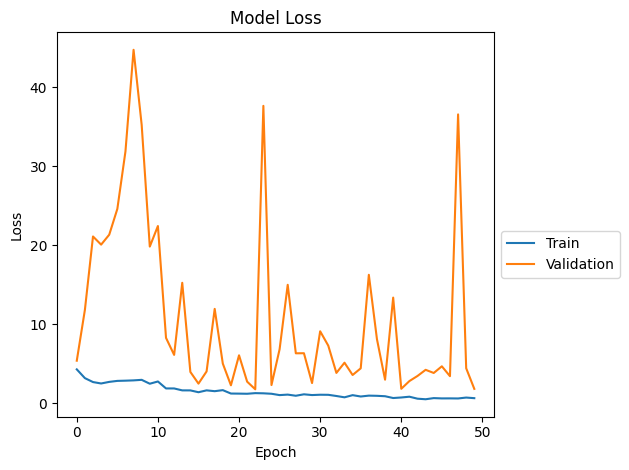

In [29]:
plot_loss(base_cnn_history,'loss')

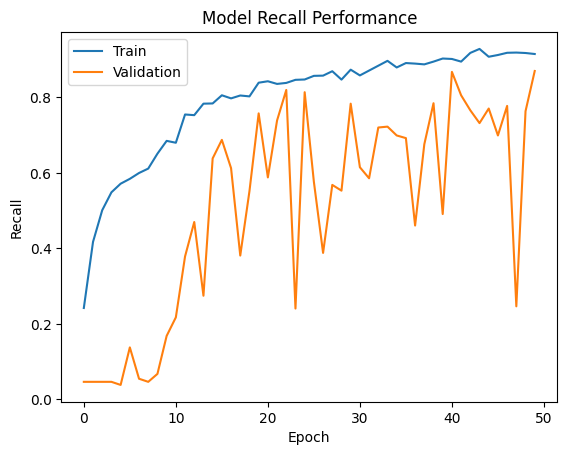

In [30]:
plot_train_vs_val_recall(base_cnn_history)

**Observation:**
- Based on the model’s loss and recall performance, we can conclude that the model is performing well on the training data but struggling to generalize to unseen data. To gain a deeper understanding, let’s evaluate the model’s performance across all three datasets (training, validation, and test).

### **Evaluating the model on training data**

In [31]:
base_cnn_model_train_perf = model_performance_classification(base_cnn_model, X_train_normalized, y_train_encoded)
base_cnn_model_train_perf

107/107 [==============================] - 1s 8ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.948246,0.958051,0.95389,0.951243


### **Evaluating the model on validation data**

In [32]:
base_cnn_model_val_perf = model_performance_classification(base_cnn_model, X_val_normalized,y_val_encoded)
base_cnn_model_val_perf

27/27 [==============================] - 0s 8ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.870175,0.865584,0.883286,0.868938


### **Evaluating the model on test data**

In [33]:
base_cnn_model_test_perf = model_performance_classification(base_cnn_model, X_test_normalized,y_test_encoded)
base_cnn_model_test_perf

15/15 [==============================] - 0s 9ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.850526,0.849649,0.875761,0.854611


**Observations:**

* The model’s performance once again aligns with our observations from the plot. The overall performance on the training set is significantly better than on the validation and test sets. While the model isn’t performing poorly on the validation and test sets, the difference in performance clearly indicates overfitting. To address this, we will apply data augmentation to create a larger training set and evaluate if it helps improve the model’s generalization and overall performance.

### **Generating the predictions using test data**

In [34]:
y_base_pred=base_cnn_model.predict(X_test_normalized)
y_base_pred

15/15 [==============================] - 0s 7ms/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.4611921e-38],
       [0.0000000e+00, 9.0797249e-21, 3.9182497e-25, ..., 1.0583830e-25,
        1.0000000e+00, 2.2662445e-35],
       [0.0000000e+00, 1.4879575e-36, 2.8131160e-25, ..., 2.2569150e-23,
        1.0000000e+00, 0.0000000e+00],
       ...,
       [1.9189450e-03, 0.0000000e+00, 6.9732823e-32, ..., 0.0000000e+00,
        0.0000000e+00, 5.7565218e-38],
       [0.0000000e+00, 8.7810791e-36, 3.9404021e-31, ..., 1.5187837e-01,
        9.4873566e-31, 2.8417226e-13],
       [0.0000000e+00, 1.0035386e-30, 3.0338407e-29, ..., 1.0000000e+00,
        1.2586467e-31, 1.5053332e-25]], dtype=float32)

### **Plotting the Confusion Matrix**

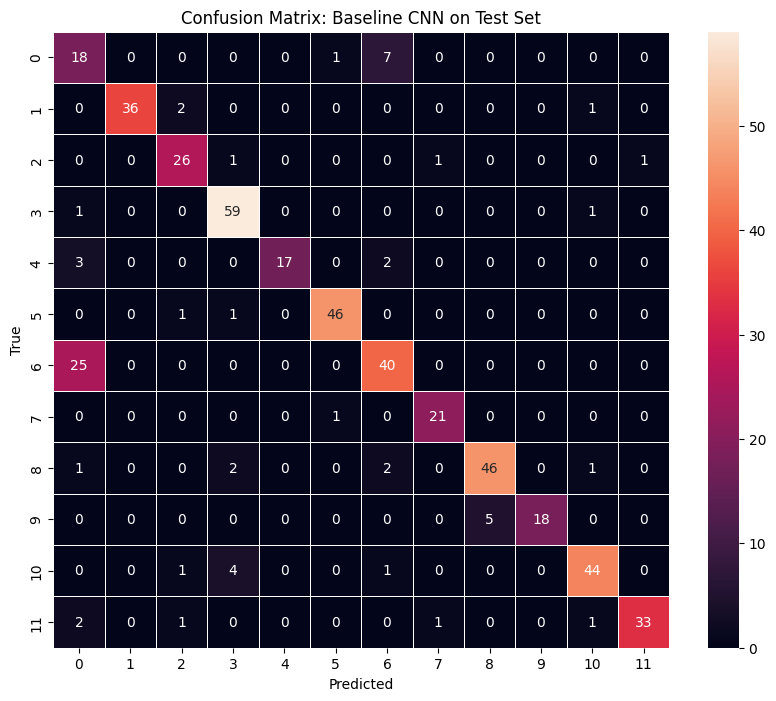

In [35]:
plot_confusion_matrix(y_base_pred,y_test_encoded, "Confusion Matrix: Baseline CNN on Test Set")

**Observation:**
- From the confusion matrix, we can observe that the model is somewhat confused between class 6 ('Loose Silky-bent') and class 0 ('Black-grass'). The performance for the other classes is comparatively better.

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [36]:
callbacks = [reduce_lr, early_stopping]

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [37]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [38]:
augmented_model = build_base_model(name="CNN_Model_with_Data_Augmentation")

Model: "CNN_Model_with_Data_Augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None

In [39]:
start = time.time()
augmented_model_history = augmented_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=rn,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1,
                    callbacks=callbacks)
end=time.time()

Epoch 1/50
53/53 [==============================] - 3s 50ms/step - loss: 1.9700 - recall: 0.2125 - accuracy: 0.3656 - val_loss: 2.7904 - val_recall: 0.0000e+00 - val_accuracy: 0.1275 - lr: 0.0010
Epoch 2/50
53/53 [==============================] - 2s 43ms/step - loss: 1.5115 - recall: 0.3751 - accuracy: 0.5164 - val_loss: 4.1489 - val_recall: 0.0000e+00 - val_accuracy: 0.0468 - lr: 0.0010
Epoch 3/50
53/53 [==============================] - 2s 43ms/step - loss: 1.3274 - recall: 0.4607 - accuracy: 0.5682 - val_loss: 7.0865 - val_recall: 0.0468 - val_accuracy: 0.0468 - lr: 0.0010
Epoch 4/50
53/53 [==============================] - 2s 43ms/step - loss: 1.2161 - recall: 0.5253 - accuracy: 0.6171 - val_loss: 11.2061 - val_recall: 0.1380 - val_accuracy: 0.1380 - lr: 0.0010
Epoch 5/50
53/53 [==============================] - 2s 43ms/step - loss: 1.1104 - recall: 0.5763 - accuracy: 0.6448 - val_loss: 13.1394 - val_recall: 0.1380 - val_accuracy: 0.1380 - lr: 0.0010
Epoch 6/50
53/53 [============

In [40]:
print("Time taken in seconds ",end-start)

Time taken in seconds  117.41335701942444


In [41]:
val_recall_values = augmented_model_history.history['val_recall']
best_epoch = np.argmax(augmented_model_history.history['val_recall']) + 1
best_val_recall = val_recall_values[best_epoch - 1]
print(f"The best epoch was: {best_epoch} and best recall was: {best_val_recall}")

The best epoch was: 33 and best recall was: 0.8491228222846985


### **Model Evaluation**

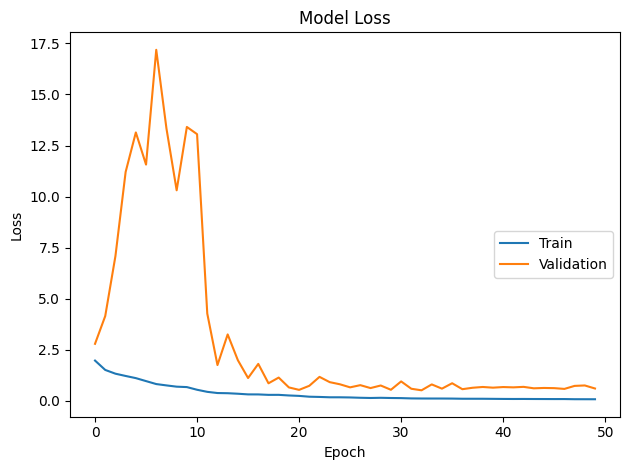

In [42]:
plot_loss(augmented_model_history,'loss')

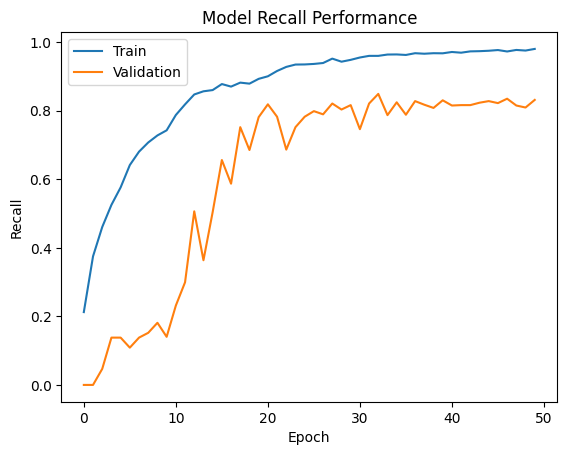

In [43]:
plot_train_vs_val_recall(augmented_model_history)

**Observation:**
- From the model’s loss and recall performance, we can see that initially, there was a large gap between validation and training performance. However, as the epochs increased, the model seemed to generalize much better compared to the base model. Let’s now evaluate the overall performance of the augmented model.

### **Evaluating the model on training data**

In [44]:
augmented_model_train_perf = model_performance_classification(augmented_model, X_train_normalized, y_train_encoded)
augmented_model_train_perf

107/107 [==============================] - 1s 8ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.855556,0.85789,0.847226,0.849065


We can observe that our accuracy has improved compared to our previous model.

### **Evaluating the model on validation data**

In [45]:
augmented_model_val_perf = model_performance_classification(augmented_model, X_val_normalized,y_val_encoded)
augmented_model_val_perf

27/27 [==============================] - 0s 8ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.837427,0.83321,0.833914,0.826483


### **Evaluating the model on test data**

In [46]:
augmented_model_test_perf = model_performance_classification(augmented_model, X_test_normalized,y_test_encoded)
augmented_model_test_perf

15/15 [==============================] - 0s 8ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.831579,0.827347,0.83069,0.823576


**Observation:**
- We can now confirm that the model is generalizing much better than the previous one, and its performance is also good. Let’s check the confusion matrix to identify any patterns.

### **Generating the predictions using test data**

In [47]:
y_augmented_pred=augmented_model.predict(X_test_normalized)

15/15 [==============================] - 0s 6ms/step


### **Plotting the Confusion Matrix**

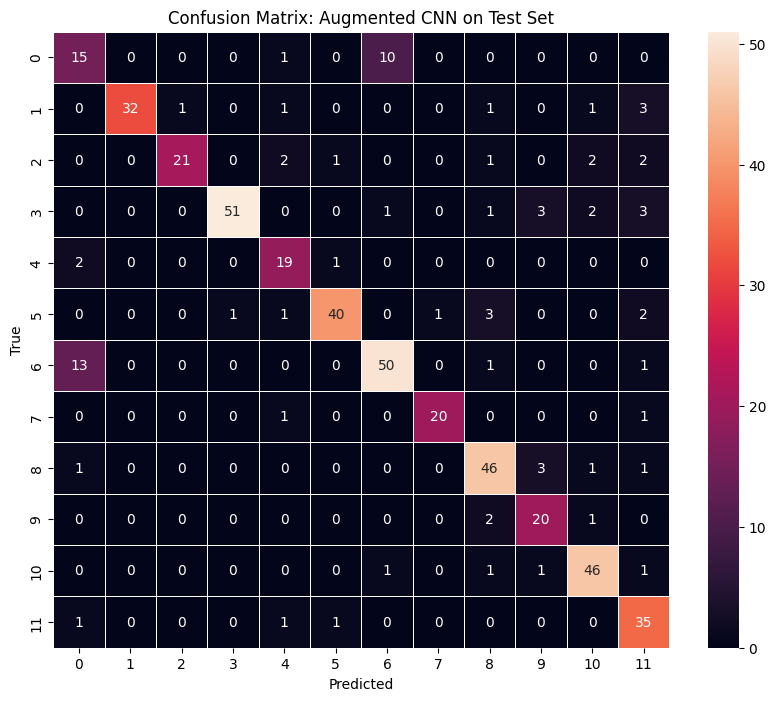

In [48]:
plot_confusion_matrix(y_augmented_pred,y_test_encoded, "Confusion Matrix: Augmented CNN on Test Set")

**Observation:**
- The confusion matrix shows that the model is still somewhat confused between class 6 (‘Loose Silky-bent’) and class 0 (‘Black-grass’). Although the number of incorrect predictions for class 6 has decreased, the incorrect predictions for class 0 have increased slightly. Overall, we can say that while the issue persists, it has reduced.
- The performance for the other classes is comparatively better.
- Next, we will use Transfer Learning with VGG16 to see if we can achieve better results.

# Transfer Learning using VGG16

- Let's try again, but this time, we will be using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.


In [49]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [50]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [51]:
print(type(vgg_model.output))  # Should be a Tensor, not a tuple

<class 'keras.src.engine.keras_tensor.KerasTensor'>


In [52]:
backend.clear_session()

x = vgg_model.output  # This should be a single tensor, not a tuple

print(type(x))

# ✅ Ensure 'Flatten' gets a tensor
x = Flatten()(x)  # Use the tensor directly
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
output_layer = Dense(12, activation='softmax')(x)

# Create a new model using the Functional API
transfer_learning_model = Model(inputs=vgg_model.input, outputs=output_layer, name="Transfer_Learning_Model")

opt=Adam()
transfer_learning_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall()])

transfer_learning_model.summary()

<class 'keras.src.engine.keras_tensor.KerasTensor'>
Model: "Transfer_Learning_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                         

In [53]:
start = time.time()
vgg16_model_history = transfer_learning_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    callbacks= callbacks,                              
                    verbose=1)
end = time.time()

Epoch 1/50
53/53 [==============================] - 5s 94ms/step - loss: 2.3863 - recall: 0.0667 - val_loss: 1.9133 - val_recall: 0.1415 - lr: 0.0010
Epoch 2/50
53/53 [==============================] - 5s 90ms/step - loss: 1.9359 - recall: 0.1582 - val_loss: 1.7105 - val_recall: 0.2000 - lr: 0.0010
Epoch 3/50
53/53 [==============================] - 5s 90ms/step - loss: 1.7079 - recall: 0.2131 - val_loss: 1.6856 - val_recall: 0.2713 - lr: 0.0010
Epoch 4/50
53/53 [==============================] - 5s 90ms/step - loss: 1.5795 - recall: 0.2527 - val_loss: 1.4794 - val_recall: 0.2690 - lr: 0.0010
Epoch 5/50
53/53 [==============================] - 5s 90ms/step - loss: 1.4455 - recall: 0.3105 - val_loss: 1.5450 - val_recall: 0.2924 - lr: 0.0010
Epoch 6/50
53/53 [==============================] - 5s 90ms/step - loss: 1.4177 - recall: 0.3439 - val_loss: 1.4849 - val_recall: 0.3368 - lr: 0.0010
Epoch 7/50
53/53 [==============================] - 5s 90ms/step - loss: 1.2775 - recall: 0.3719 - v

In [54]:
import tensorflow as tf
import keras

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

TensorFlow Version: 2.15.0
Keras Version: 2.15.0


In [55]:
print("Time taken in seconds ",end-start)

Time taken in seconds  242.1367290019989


### **Model Evaluation**

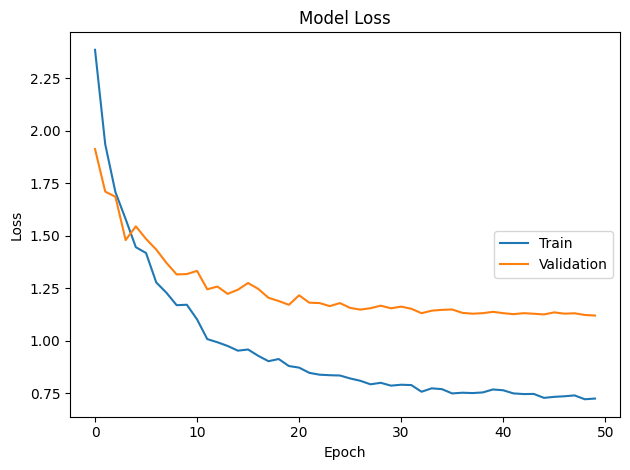

In [56]:
plot_loss(vgg16_model_history,'loss')

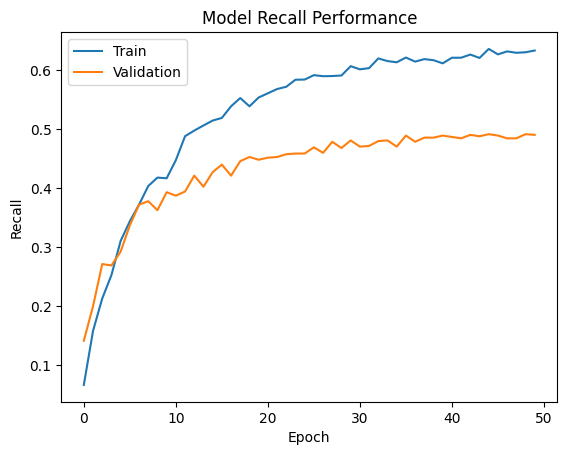

In [57]:
plot_train_vs_val_recall(vgg16_model_history)

**Observation:**
- From the model’s loss and recall performance, we can see that the gap between validation and training performance increases as the epochs progress, which is a sign of overfitting. Despite this, the overall performance of the model is still not satisfactory.

### **Evaluating the model on train data**

In [58]:
vgg16_model_train_perf = model_performance_classification(transfer_learning_model, X_train_normalized, y_train_encoded)
vgg16_model_train_perf

107/107 [==============================] - 4s 39ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.695906,0.648565,0.710509,0.658585


### **Evaluating the model on validation data**

In [59]:
vgg16_model_val_perf = model_performance_classification(transfer_learning_model, X_val_normalized,y_val_encoded)
vgg16_model_val_perf

27/27 [==============================] - 1s 41ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.615205,0.544667,0.601456,0.548655


### **Evaluating the model on test data**

In [60]:
vgg16_model_test_perf = model_performance_classification(transfer_learning_model, X_test_normalized,y_test_encoded)
vgg16_model_test_perf

15/15 [==============================] - 1s 44ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.614737,0.560032,0.604176,0.565373


**Observation:**
- The model’s performance is worse than the baseline, suggesting that VGG16 might not be the most suitable transfer learning model for this task. We need to explore other models that may be more appropriate for achieving better results with transfer learning.

### **Generating the predictions using test data**

In [61]:
y_vgg16_pred=transfer_learning_model.predict(X_test_normalized)

15/15 [==============================] - 1s 38ms/step


### **Plotting the Confusion Matrix**

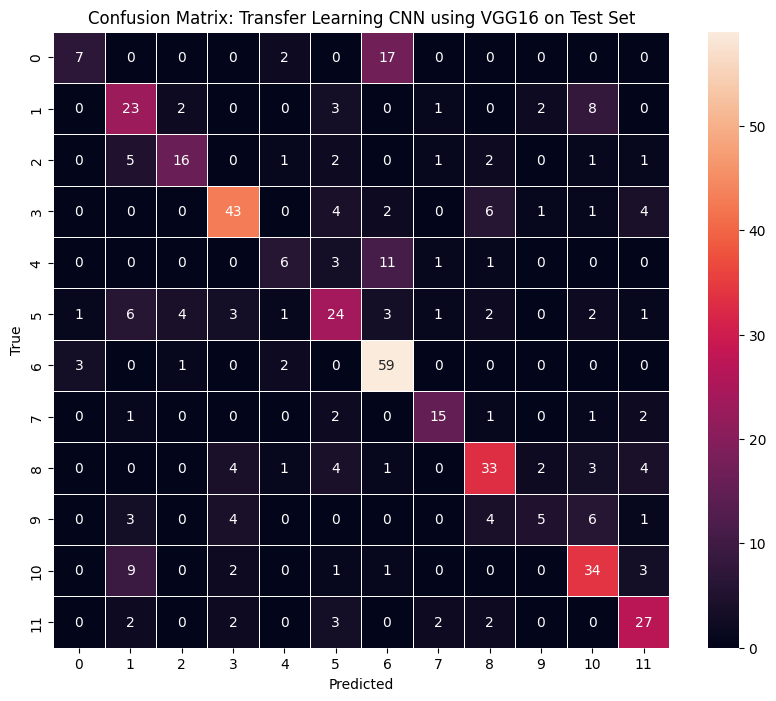

In [62]:
plot_confusion_matrix(y_vgg16_pred,y_test_encoded, "Confusion Matrix: Transfer Learning CNN using VGG16 on Test Set")

**Observation:**

- The confusion matrix shows that this model is performing worse than all previous models. A significant number of misclassifications occur with class 0 and class 4 , which are often predicted as class 6.

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

In [63]:
# training performance comparison

models_performance_comparision_train_df = pd.concat(
    [
        base_cnn_model_train_perf.T,
        augmented_model_train_perf.T,
        vgg16_model_train_perf.T
    ],
    axis=1,
)
models_performance_comparision_train_df.columns = [
    "Basic CNN Model (Full Sptial Detail)",
    "CNN using Augmented Training Data (Overfitting Reduction)",
    "CNN using Transfer Learning (VGG16)",
]

In [64]:
print("Different Model Performance On Training Data:")
models_performance_comparision_train_df

Different Model Performance On Training Data:


,Basic CNN Model (Full Sptial Detail),CNN using Augmented Training Data (Overfitting Reduction),CNN using Transfer Learning (VGG16)
Accuracy,0.948246,0.855556,0.695906
Recall,0.958051,0.857890,0.648565
Precision,0.953890,0.847226,0.710509
F1 Score,0.951243,0.849065,0.658585


In [65]:
# training performance comparison

models_performance_comparision_val_df = pd.concat(
    [
        base_cnn_model_val_perf.T,
        augmented_model_val_perf.T,
        vgg16_model_val_perf.T
    ],
    axis=1,
)
models_performance_comparision_val_df.columns = [
    "Basic CNN Model (Full Sptial Detail)",
    "CNN using Augmented Training Data (Overfitting Reduction)",
    "CNN using Transfer Learning (VGG16)",
]

In [66]:
print("Different Model Performance On Validation Data:")
models_performance_comparision_val_df

Different Model Performance On Validation Data:


,Basic CNN Model (Full Sptial Detail),CNN using Augmented Training Data (Overfitting Reduction),CNN using Transfer Learning (VGG16)
Accuracy,0.870175,0.837427,0.615205
Recall,0.865584,0.833210,0.544667
Precision,0.883286,0.833914,0.601456
F1 Score,0.868938,0.826483,0.548655


In [67]:
# training performance comparison

models_performance_comparision_test_df = pd.concat(
    [
        base_cnn_model_test_perf.T,
        augmented_model_test_perf.T,
        vgg16_model_test_perf.T
    ],
    axis=1,
)
models_performance_comparision_test_df.columns = [
    "Basic CNN Model (Full Sptial Detail)",
    "CNN using Augmented Training Data (Overfitting Reduction)",
    "CNN using Transfer Learning (VGG16)",
]

In [68]:
print("Different Model Performance On Test Data:")
models_performance_comparision_test_df

Different Model Performance On Test Data:


,Basic CNN Model (Full Sptial Detail),CNN using Augmented Training Data (Overfitting Reduction),CNN using Transfer Learning (VGG16)
Accuracy,0.850526,0.831579,0.614737
Recall,0.849649,0.827347,0.560032
Precision,0.875761,0.830690,0.604176
F1 Score,0.854611,0.823576,0.565373


**Observation:**

- Both the baseline and augmented models perform well overall, with the baseline achieving the best performance. However, due to overfitting issues, we will choose the augmented model as our final model and proceed with the final prediction.

### Visualizing the prediction

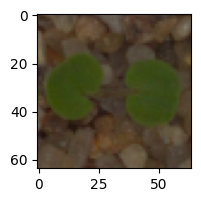

1/1 [==============================] - 1s 922ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


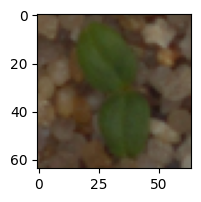

1/1 [==============================] - 0s 10ms/step
Predicted Label ['Cleavers']
True Label Cleavers


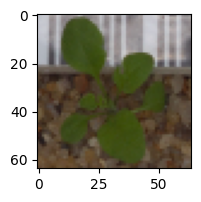

1/1 [==============================] - 0s 10ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [69]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(augmented_model.predict((X_test_normalized[2].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[2])

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(augmented_model.predict((X_test_normalized[33].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[33])

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(augmented_model.predict((X_test_normalized[36].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[36])

**Observation:**

- Using the augmented model, all three selected images are predicted correctly.

## Actionable Insights and Business Recommendations

* Although the augmented model’s overall performance is slightly worse than the baseline model, it is more likely to perform better in production due to its consistent performance across the training, validation, and testing datasets.
* The test accuracy for the baseline model is 85.05%, the augmented model is 83.15%, and the VGG16 architecture-based model is 61.47%.
* The time taken by both the baseline and augmented models is almost the same. However, the transfer learning model takes more than double the time to train. So, when choosing a model, we should also consider the training time.
* Class weights helped balance the class distribution, ensuring fair treatment of each class.
* Data augmentation has contributed to the overall improvement of the model. In the future, we can experiment with different parameters for generating augmented data to further enhance the model.
* Experimenting with different filter numbers and sizes may reveal better configurations and could positively impact the model’s performance.
* Both baseline and augmented models show confusion between class 0 and class 6. A deeper analysis of these classes is needed to identify why this confusion occurs and how to address it for improvement.
* We used 64x64 images to reduce training time and computational cost. But using smaller images might make it harder for the model to see smaller details (fine-grained features). If we have a stronger computer, we could try using 128x128 images, which might help the model learn more details and improve its performance.
* We can also experiment with varying dropout rates, learning rates, and batch sizes to assess their effect on the model’s performance.
* In our case, VGG16 did not outperform the other two models. In the future, we can try other transfer learning architectures to see if they perform better.

_____